In [1]:
!pip install portalocker

In [2]:
# 0.18(2024-09-25時点で最新)だと動かない... 0.16は動いたのでこっちで
!pip install torchtext==0.16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209

In [3]:
# colabの準備
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)
import sys
now_path = drive_path + "/MyDrive/深層学習/RNN"
sys.path.append(now_path)

Mounted at /content/drive


In [4]:
# ライブラリ
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from gensim.models import KeyedVectors
# import pandas as pd
# 講座ではpandasだが、練習のためpolarsを使用
import polars as pl

In [5]:
data = AG_NEWS('./ag_news', split='train')

In [6]:
list(data)[:3]

[(3,
  "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'),
 (3,
  "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")]

In [7]:
label,sentence = next(iter(data))

In [8]:
sentence

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [9]:
label

3

In [10]:
# 学習データ10%, 検証データ9%
# 1: "World", 2:"Sports", 3:"Business", "Sci/Tech"
data = list(data)
train_data, remain_train = train_test_split(data, train_size=0.1, random_state=0)
_, val_data = train_test_split(remain_train, test_size=0.1, random_state=0)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [11]:
labels = [label for label, text in data]
labels = pl.Series(labels)

In [12]:
labels.value_counts()

,count
i64,u32
1,30000
3,30000
2,30000
4,30000


<Axes: ylabel='Count'>

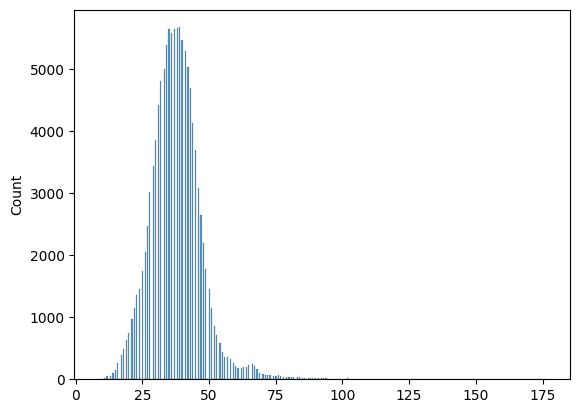

In [13]:
text_length = pl.Series([len(text.split()) for _, text in data])
sns.histplot(text_length)

# イテレーターとは
### イテレーターは、__iter__()メソッドと__next__()メソッドを持つオブジェクトのこ とを指します。__next__()を使って次の要素を順番に返し、要素がなくなるとStopIteration例外を発生させます。イテレーターは、forループなどで順次要素を取り出す際に利用されます。

# ジェネレーターの役割
### ジェネレーターは、特別な方法でイテレーターを簡単に作成できる仕組みです。yieldを使った関数は自動的にイテレーターとして振る舞い、__iter__()と__next__()メソッドを自動的に実装したジェネレーターオブジェクトを生成します。

### データ準備

In [14]:
tokenizer = get_tokenizer("basic_english")

In [15]:
tokenizer('I am a student (students-j3)') # 単語で分割してくれる(大文字、小文字の区別はない)

['i', 'am', 'a', 'student', '(', 'students-j3', ')']

In [16]:
for _, text in data[:3]:
    print(tokenizer(text))

['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']
['carlyle', 'looks', 'toward', 'commercial', 'aerospace', '(', 'reuters', ')', 'reuters', '-', 'private', 'investment', 'firm', 'carlyle', 'group', ',', '\\which', 'has', 'a', 'reputation', 'for', 'making', 'well-timed', 'and', 'occasionally\\controversial', 'plays', 'in', 'the', 'defense', 'industry', ',', 'has', 'quietly', 'placed\\its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market', '.']
['oil', 'and', 'economy', 'cloud', 'stocks', "'", 'outlook', '(', 'reuters', ')', 'reuters', '-', 'soaring', 'crude', 'prices', 'plus', 'worries\\about', 'the', 'economy', 'and', 'the', 'outlook', 'for', 'earnings', 'are', 'expected', 'to\\hang', 'over', 'the', 'stock', 'market', 'next', 'week', 'during', 'the', 'depth', 'of', 'the\\summer', 'doldrums',

### イテレーター作成

In [17]:
# ジェネレーターはイテラブル
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [18]:
genereter = yield_tokens(data)
a = next(genereter)
b = next(genereter)

In [19]:
a

['wall',
 'st',
 '.',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'short-sellers',
 ',',
 'wall',
 'street',
 "'",
 's',
 'dwindling\\band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.']

In [20]:
b

['carlyle',
 'looks',
 'toward',
 'commercial',
 'aerospace',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'private',
 'investment',
 'firm',
 'carlyle',
 'group',
 ',',
 '\\which',
 'has',
 'a',
 'reputation',
 'for',
 'making',
 'well-timed',
 'and',
 'occasionally\\controversial',
 'plays',
 'in',
 'the',
 'defense',
 'industry',
 ',',
 'has',
 'quietly',
 'placed\\its',
 'bets',
 'on',
 'another',
 'part',
 'of',
 'the',
 'market',
 '.']

### 辞書作成

In [21]:
vocab = build_vocab_from_iterator(yield_tokens(data), specials=['<unk>'])

In [22]:
vocab['hello']

12544

In [23]:
vocab['<unk>']

0

In [24]:
# .set_default_index(0)
vocab.set_default_index(vocab['<unk>']) # set_default_indexで辞書にない単語のデフォルトのindexを指定

In [25]:
vocab['xxxxx']

0

In [26]:
# vocab.get_itos()[vocab['hello']]
vocab.get_itos()[12544] # 単語のリスト

'hello'

#### DataLoader作成

In [27]:
vocab['wall']

431

In [28]:
vocab['wall']

431

In [29]:
sentences = []
labels = []
for label, text in data:
    label += 1
    labels.append(label)
    sentence = [vocab[tanngo] for tanngo in tokenizer(text)]
    sentences.append(sentence)

In [30]:
sentences[:2]

[[431,
  425,
  1,
  1605,
  14838,
  113,
  66,
  2,
  848,
  13,
  27,
  14,
  27,
  15,
  50725,
  3,
  431,
  374,
  16,
  9,
  67507,
  6,
  52258,
  3,
  42,
  4009,
  783,
  325,
  1],
 [15874,
  1072,
  854,
  1310,
  4250,
  13,
  27,
  14,
  27,
  15,
  929,
  797,
  320,
  15874,
  98,
  3,
  27657,
  28,
  5,
  4459,
  11,
  564,
  52790,
  8,
  80617,
  2125,
  7,
  2,
  525,
  241,
  3,
  28,
  3890,
  82814,
  6574,
  10,
  206,
  359,
  6,
  2,
  126,
  1]]

In [73]:
# batch: [(label, text), (label, text), ...,]
# この関数がDataLoderのイテレーションが回るごとに実行される
def collate_batch(batch):
    sentences = []
    labels = []

    for label, text in batch :
    # label , textに対する処理
        label -= 1
        labels.append(label)
        sentence = [vocab[tanngo] for tanngo in tokenizer(text)]
        sentences.append(sentence)
    # # # padding
    pad_sentences = pad_sequence([torch.tensor(sentence) for sentence in sentences], batch_first=True)
    labels = torch.tensor(labels)

    return labels, pad_sentences


In [74]:
labels, sentences = collate_batch(train_data[0:8])

In [75]:
sentences.shape

torch.Size([8, 66])

In [76]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [77]:
sentence, label = next(iter(train_loader))

In [78]:
sentence

tensor([1, 2, 0, 0, 1, 0, 2, 1])

In [79]:
label

tensor([[ 1132,    12,  3072,  8652,  1899,     3,  4892,  1899,   228,   438,
            15,    30, 17828, 36857,    62, 21845, 15197,    18, 52726,     3,
          4254, 62317,  3268,    32, 30058,    29,    32, 34489,     3,    32,
         22134,    29,    32, 13604,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  953,   292,   371,     4,  6787,  6492,     3,   108,     3,  1283,
           329,   236,     3,   315,    53,   168,  2512,   246,   953,   292,
           371,    21,     4,   414,   161,     6,    22,   732,  8772,  6492,
            18,     2,   296,     6,    68,   108,     3,  1283,   329,     3,
             2,    54,   134,     1,     0,     0],
        [ 2650,  3359,   344,    29,    36,  5569,     7,    70,     5,   131,
          3359,     4,  2353,   208,  1192,  5021,  2538,    35,  1861,    29,
            36,  5569,    10,    60,     3,    30,  3359,     4,  2650,    26,
             1,  6634, 7865

### word embedding

In [80]:
# gensimのword2vecを使用
word2Vec = KeyedVectors.load_word2vec_format(now_path + "/GoogleNews-vectors-negative300.bin", binary=True)

In [81]:
# embedding matrixを作成
# 今回は、embedding dimを300にする
embedding_matrix = torch.zeros((len(vocab), 300))

In [82]:
# vocabのインデックスが2の文字を取得して、これに対して、既に作成されたベクトルをembedding matrixに埋め込む
print(f'vocab.get_itos()[2] is "{vocab.get_itos()[2]}".')
print()
# print(f'word2Vec[vocab.get_itos()[2]] is {word2Vec[vocab.get_itos()[2]]}')
embedding_matrix[2] = torch.from_numpy(word2Vec[vocab.get_itos()[2]])

embedding_matrix

vocab.get_itos()[2] is "the".



tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0801,  0.1050,  0.0498,  ...,  0.0037,  0.0476, -0.0688],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [83]:
# これをvocab内の全データに対して行う

# unkownには word2vec全体の平均の単語ベクトルを適用する
unk_vector = torch.from_numpy(np.mean(word2Vec.vectors, axis=0))

for i, word in enumerate(vocab.get_itos()):
    if word in word2Vec:
        embedding_matrix[i] = torch.from_numpy(word2Vec[word])
    else:
        embedding_matrix[i] = unk_vector

In [84]:
# これで今回のdataに対応したembeddig matrixを作成できた
embedding_matrix

tensor([[-2.2573e-04, -1.0131e-03, -1.0477e-02,  ..., -2.7636e-02,
          6.1091e-02,  3.8046e-02],
        [-2.2573e-04, -1.0131e-03, -1.0477e-02,  ..., -2.7636e-02,
          6.1091e-02,  3.8046e-02],
        [ 8.0078e-02,  1.0498e-01,  4.9805e-02,  ...,  3.6621e-03,
          4.7607e-02, -6.8848e-02],
        ...,
        [-1.7480e-01,  5.5664e-02,  1.1353e-02,  ...,  7.7637e-02,
          1.6016e-01,  1.3281e-01],
        [-1.0498e-01,  9.3750e-02,  6.3965e-02,  ...,  2.3804e-02,
         -4.6387e-02,  4.4141e-01],
        [-3.4912e-02,  1.4746e-01, -2.9541e-02,  ...,  2.8320e-02,
          6.2256e-02,  1.7773e-01]])

### モデルの定義

In [106]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size , embedding_matrix=None, num_layers=1, rnn_type='LSTM', bidirectional=False):

        super().__init__()
        self.num_directions = 2 if bidirectional else 1

        # embedding layer追加 (vocab_size x embedding_dim)
        if embedding_matrix is None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        else:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        input_size = embedding_dim

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU"]')

        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self._wight_initialize()

    def _wight_initialize(self):
        """
        パラメータの初期を行うようにする関数.
        コンストラクタとして実行
        """
        # ネストが深い...
        for name, module in self.named_modules():
            if name:

                if isinstance(module, nn.Linear):
                    nn.init.kaiming_normal_(module.weight)

                if isinstance(module, (nn.RNN, nn.LSTM, nn.GRU)):
                    for param_name, param in module.named_parameters():
                        if 'weight' in param_name:
                            nn.init.xavier_normal_(param)



    def forward(self, x):
        x = self.embedding(x)
        output_seq, _ = self.rnn(x)

        # import pdb; pdb.set_trace()
        out = self.fc(output_seq[:, -1, :]) # [batch_size, hidden_size * num_directions]
        return out

In [112]:
vocab_size = len(vocab)
embedding_dim=300
num_layers = 1
model = Model(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=200, output_size=4, \
              embedding_matrix=None, num_layers=num_layers, rnn_type='LSTM', bidirectional=True)

out = model(sentences)
out.shape

torch.Size([8, 4])

### 学習ループ

In [116]:
vocab_size = len(vocab)
num_classes = 4
embedding_dim=300
learning_rate = 0.001
output_size = num_classes
num_epochs = 7
num_layers = 3


# モデルの定義
model = Model(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=200, output_size=4, \
              embedding_matrix=embedding_matrix, num_layers=num_layers, rnn_type='LSTM', bidirectional=True)

# 損失関数とoptimizer
opt = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()




def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, learning_rate=0.01):

    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []


    # GPU設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        total_correct = 0

        # training
        for i, (labels, sentences) in tqdm(enumerate(train_loader), desc='now training', total=len(train_loader), leave=False):
            sentences = sentences.to(device)
            # import pdb; pdb.set_trace()
            labels = labels.to(device)
            opt.zero_grad()
            output = model(sentences) # [batch_size,  num_classes]
            loss = criterion(output, labels)
            loss.backward()
            running_loss += loss.item()
            opt.step()
        train_losses.append(running_loss / len(train_loader))

        # validation
        # 評価用

        total_num = 0
        total_correct = 0

        for i, (labels, sentences) in tqdm(enumerate(val_loader), desc='valdation', total=len(val_loader), leave=False):

            model.eval()
            with torch.no_grad():

                sentences = sentences.to(device)
                labels = labels.to(device)
                output = model(sentences) # [batch_size, 1, num_classes]

                # accuracy計算
                _, predicted = torch.max(output, -1) #[batch_size, 1]
                total_correct += torch.sum(predicted == labels).item()
                total_num += labels.numel() # [batch_size * seq_len]


                loss = criterion(output, labels)
                running_val_loss += loss.item()

        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(total_correct / total_num)
        print(f"epoch={epoch}  train_losse={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f} val_accuracy={val_accuracies[-1]:.4f}")
    return train_losses, val_losses, val_accuracies

In [117]:
train_losses, val_losses, val_accuracies = train(model, train_loader, val_loader, opt, criterion, num_epochs, learning_rate)

epoch=0  train_losse=1.0976 val_loss=0.5610 val_accuracy=0.7574


epoch=1  train_losse=0.4349 val_loss=0.3375 val_accuracy=0.8933


epoch=2  train_losse=0.2077 val_loss=0.3381 val_accuracy=0.8947


epoch=3  train_losse=0.1004 val_loss=0.3996 val_accuracy=0.8838


epoch=4  train_losse=0.0458 val_loss=0.5100 val_accuracy=0.8686


epoch=5  train_losse=0.0244 val_loss=0.5615 val_accuracy=0.8725


epoch=6  train_losse=0.0199 val_loss=0.5873 val_accuracy=0.8741


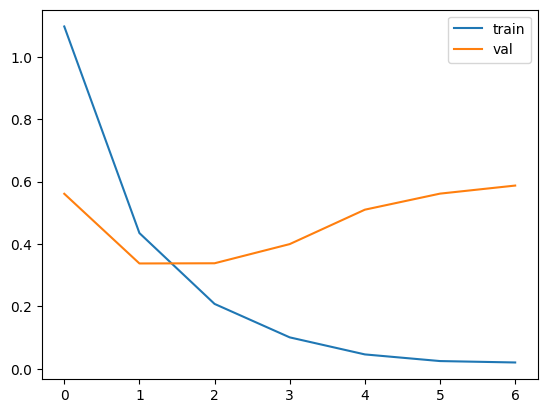

In [118]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()